# Overview of this jupyter notebook

1. Loading data
2. Data Preprocessing
<br>2.1 Creating train, val and test data (only first 100 datapoints are used)
<br>2.2 Normalizing the data sets
3. CAE Hyperparameteroptimization
<br>3.1 Searching the optimal CAE structure with train reconstruction loss (MAE)
4.Searching optimal threshold through several methods
<br>4.1 Searching threshold with validation data
<br>4.2 Calculating threshold with mean and standard deviation
<br>4.3 Calculating threshold with max train error
5. Evaluation
<br>5.1 Evaluation with optimized threshold through validation data
<br>5.2 Evaluation with optimized threshold through standard deviation
<br>5.3 Evaluation with optimized threshold through max reconstrucion error

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
import pickle
import json
import random

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization, UpSampling1D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import os
import importlib
from library import faps_color as fapsc          # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
from library import autoencoder_helper as ah     #  this module contains helper functions for the anomaly detection task  
print(importlib.reload(fapsc))
print(importlib.reload(ch))
print(importlib.reload(ah))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>
<module 'library.autoencoder_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\autoencoder_helper.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


In [5]:
!python -V

Python 3.10.6


# 1. Loading data

In [6]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
feature_train = np.load("feature_label/occ_feature_train_v2.4.npy")
feature_train.shape

(2150, 920)

In [7]:
feature_test = np.load("feature_label/occ_feature_test_v2.4.npy")
feature_test.shape

(750, 920)

In [8]:
label_train = np.load("feature_label/occ_label_train_v2.4.npy")
label_train.shape

(2150, 8)

In [9]:
label_test = np.load("feature_label/occ_label_test_v2.4.npy")
label_test.shape

(750, 8)

# 2. Data Preprocessing

## 2.1 Creating train, val and test data

In [12]:
# using only curves from class 0 for x_train
# x_test contains 50 curves from each 15 classes

x_train = feature_train[:700, :100]   # only first 100 datapoints are for training and test used
x_test = feature_test[:,:100]

x_train.shape, x_test.shape

((700, 100), (750, 100))

In [13]:
y_train = (np.argmax(label_train, axis=1)>0).astype(int)
y_test = (np.argmax(label_test, axis=1)>0).astype(int)
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
(y_test==0).sum()

50

In [10]:
# train_sector describes from which row feature_train each defect class begin

train_sector = np.array([750, 900, 1050, 1200, 1350, 1500, 1650, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150])
train_sector

array([ 750,  900, 1050, 1200, 1350, 1500, 1650, 1800, 1850, 1900, 1950,
       2000, 2050, 2100, 2150])

In [15]:
# 30 curves from class 0 and 5 curves of each defect class are saved in validation data to optimize the threshold 

x_val = feature_train[720:750, :100]   # only first 100 datapoints are for validation used

for i in train_sector[:-1]:
    for j in range(5):
        x_val = np.append(x_val, [feature_train[i+10+j,:100]], axis=0)

x_val.shape

(100, 100)

In [16]:
y_val = np.zeros(100).astype(int)
y_val[30:] = 1
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 2.2 Normalizing the data sets

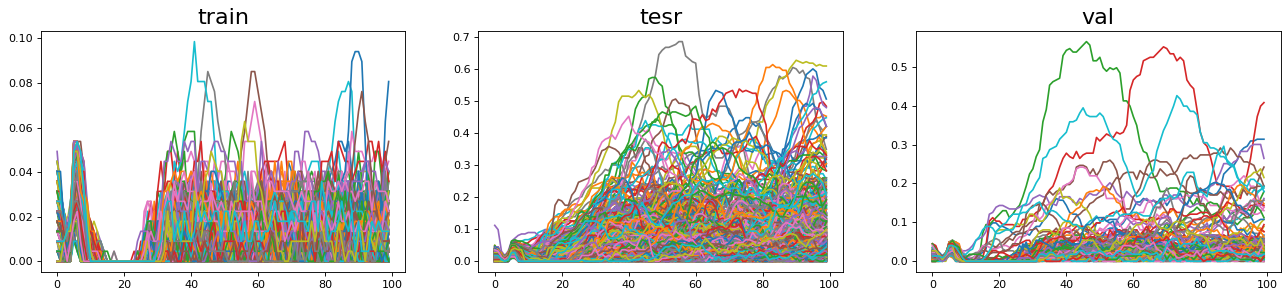

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20,4), dpi=80)
axs[0].plot(x_train.transpose())
axs[1].plot(x_test.transpose())
axs[2].plot(x_val.transpose())

axs[0].set_title("train", fontsize=20)
axs[1].set_title("tesr", fontsize=20)
axs[2].set_title("val", fontsize=20)
fig.show()

In [18]:
#normalize data by dividing through max_train

max_train = np.load("dataframes/max_train_v2.npy")
min_train = np.min(x_train)

x_train_scaled = x_train / max_train
x_test_scaled = x_test / max_train
x_val_scaled = x_val / max_train

min_train, max_train

(0.0, array(2.56704))

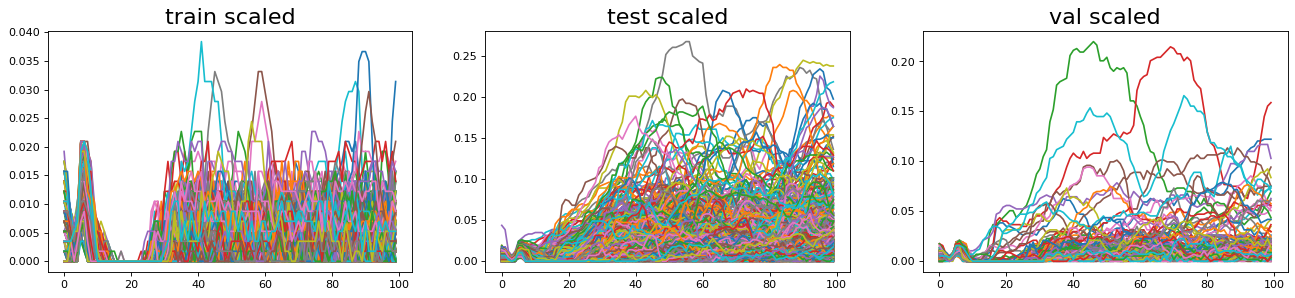

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20,4), dpi=80)
axs[0].plot(x_train_scaled.transpose())
axs[1].plot(x_test_scaled.transpose())
axs[2].plot(x_val_scaled.transpose())

axs[0].set_title("train scaled", fontsize=20)
axs[1].set_title("test scaled", fontsize=20)
axs[2].set_title("val scaled", fontsize=20)
fig.show()

In [20]:
x_train_inverse = x_train_scaled * max_train
x_test_inverse = x_test_scaled * max_train
x_val_inverse = x_val_scaled * max_train

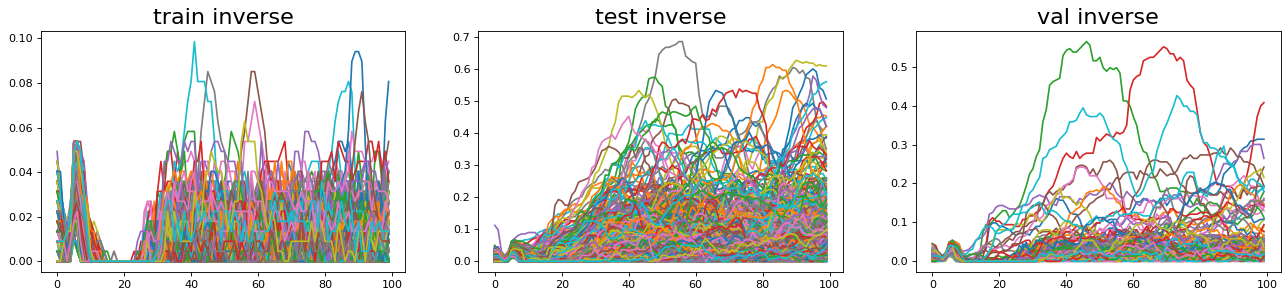

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20,4), dpi=80)
axs[0].plot(x_train_inverse.transpose())
axs[1].plot(x_test_inverse.transpose())
axs[2].plot(x_val_inverse.transpose())

axs[0].set_title("train inverse", fontsize=20)
axs[1].set_title("test inverse", fontsize=20)
axs[2].set_title("val inverse", fontsize=20)
fig.show()

In [22]:
# check, whether the inverse data is equal to original data

np.array_equal(np.round(x_train, 4), np.round(x_train_inverse, 4))

True

In [23]:
# reshape train and test data in 3 dim data for CNN AutoEncoder
len_curve = 100

x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)
x_val = x_val.reshape(-1, len_curve, 1)

x_train_scaled = x_train_scaled.reshape(-1, len_curve, 1)
x_test_scaled = x_test_scaled.reshape(-1, len_curve, 1)
x_val_scaled = x_val_scaled.reshape(-1, len_curve, 1)

In [24]:
x_train_scaled.shape, x_val_scaled.shape

((700, 100, 1), (100, 100, 1))

# 3. CAE Hyperparameteroptimization 

## 3.1 Searching the optimal CAE structure with train reconstruction loss (MAE)

In [25]:
def cae(conv, filters, kernel, strides, lr):
    
    model = Sequential()
    # encoder
    if conv >= 1:
        model.add(Conv1D(filters, kernel, strides=strides, activation="relu", padding='same', input_shape=(len_curve, 1)))
    if conv >= 2:
        model.add(Conv1D(filters, kernel, strides=strides, activation="relu", padding='same'))    
    if conv >= 3:
        model.add(Conv1D(filters, kernel, strides=strides, activation="relu", padding='same'))

    if conv >= 4:
        model.add(Conv1D(filters, kernel, strides=strides, activation="relu", padding='same'))

    
    #decoder
    if conv >= 1:
        model.add(Conv1DTranspose(filters, kernel, strides=strides, activation="relu", padding='same'))
    if conv >= 2:
        model.add(Conv1DTranspose(filters, kernel, strides=strides, activation="relu", padding='same'))
    if conv >= 3:
        model.add(Conv1DTranspose(filters, kernel, strides=strides, activation="relu", padding='same'))
    if conv >= 4:
        model.add(Conv1DTranspose(filters, kernel, strides=strides, activation="relu", padding='same'))
    
    model.add(Conv1DTranspose(1, kernel, activation='sigmoid', padding= 'same'))
    
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=["mae"])
    print(model.summary())
    return model

In [67]:
from itertools import product

conv = [2,3,4]
filters = [16,32,48]
kernel = [4,8,16]
strides=[1,2,4]
lr = [0.001, 0.005, 0.01]
batch_size = [4, 16, 32]

paramcom = product(conv, filters, kernel, strides, lr, batch_size)

In [68]:
result_dict = {"conv_layer":[], "filters":[], "kernel":[], "strides":[], "learning_rate":[], "batch_size":[],
               "mean_rmse":[], "mean_mae":[], "mean_mse":[]} 

In [69]:
# grid search to find the optimal hyperparameters for the cae

for i, com in enumerate(paramcom):
    print(f"start {i}th combination: {com}")
    try:
        model = cae(conv=com[0], filters=com[1], kernel=com[2], strides=com[3], lr=com[4])
        history = model.fit(x_train_scaled, x_train_scaled, epochs=200, batch_size=com[5], validation_split=0.2,
                            verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

        reconstructed_train_inverse = ah.reconstruct_curves(model, x_train_scaled, max_train, len_curve=100, scaled=True)
        rmse, mae, mse = ah.calc_reconstruction_loss(x_train_inverse, reconstructed_train_inverse)
        print(rmse, mae, mse)

        result_dict["conv_layer"].append(com[0])
        result_dict["filters"].append(com[1])
        result_dict["kernel"].append(com[2])
        result_dict["strides"].append(com[3])
        result_dict["learning_rate"].append(com[4])
        result_dict["batch_size"].append(com[5])
        result_dict["mean_rmse"].append(rmse)
        result_dict["mean_mae"].append(mae)
        result_dict["mean_mse"].append(mse)
        print(len(result_dict["mean_mae"]))

        print(f"end {i}th combination: {com}")
        tf.keras.backend.clear_session()
    
    except:
        result_dict["conv_layer"].append(com[0])
        result_dict["filters"].append(com[1])
        result_dict["kernel"].append(com[2])
        result_dict["strides"].append(com[3])
        result_dict["learning_rate"].append(com[4])
        result_dict["batch_size"].append(com[5])
        result_dict["mean_rmse"].append("err")
        result_dict["mean_mae"].append("err")
        result_dict["mean_mse"].append("err")
        tf.keras.backend.clear_session()
        
        print("##### exception occured #####")
        pass

start 0th combination: (2, 16, 4, 1, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          1040      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           65        
 ranspose)                                                       
         

 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0024178547856377403 0.0016966108096923677 6.057252264862341e-06
6
end 5th combination: (2, 16, 4, 1, 0.005, 32)
start 6th combination: (2, 16, 4, 1, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           80        
                                        

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 16)           1040      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           65        
 ranspose)                                                       
                                                                 
Total para

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0008668407631569803 0.0005238453550672122 9.910703154683295e-07
17
end 16th combination: (2, 16, 4, 2, 0.01, 16)
start 17th combination: (2, 16, 4, 2, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 2

 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 23th combination: (2, 16, 4, 4, 0.005, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            80        
                                    

 conv1d_transpose (Conv1DTra  (None, 100, 16)          2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0011129504018811958 0.0006816662351813779 1.3593605466861368e-06
29
end 28th combination: (2, 16, 8, 1, 0.001, 16)
start 29th combination: (2, 16, 8, 1, 0.001, 32)
Model: "sequential"
__________________________________

_________________________________________________________________
None
Epoch 70: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.0006342538429966005 0.00031541652557079603 5.929135103486114e-07
34
end 33th combination: (2, 16, 8, 1, 0.01, 4)
start 34th combination: (2, 16, 8, 1, 0.01, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           144       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           2064      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          2064      
 ranspose)    

 conv1d_transpose (Conv1DTra  (None, 50, 16)           2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________
None
Epoch 142: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.0013059882753206568 0.0007917213172409163 2.1463762155053493e-06
40
end 39th combination: (2, 16, 8, 2, 0.005, 4)
start 40th combination: (2, 16, 8, 2, 0.005, 16)
Model: "sequential"
_________

Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0037083039198510972 0.0025969809977076565 1.4717203443002597e-05
45
end 44th combination: (2, 16, 8, 2, 0.01, 32)
start 45th combination: (2, 16, 8, 4, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            144       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             2064      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 16)           2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 16)          2064      
 ranspose)    

Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 51th combination: (2, 16, 8, 4, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            144       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             2064      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 16)           2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 16)          2064      
 ranspose)                                                       
                                      

 ranspose)                                                       
                                                                 
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.004604913783771968 0.0033303484737148828 2.1753314088385146e-05
57
end 56th combination: (2, 16, 16, 1, 0.001, 32)
start 57th combination: (2, 16, 16, 1, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           272       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          4112      
 nspose)                        

 conv1d (Conv1D)             (None, 100, 16)           272       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
None
r

 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0026265940062139012 0.0018146747699863536 7.225367973370377e-06
68
end 67th combination: (2, 16, 16, 2, 0.005, 16)
start 68th combination: (2, 16, 16, 2, 0.005, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 16)            272       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            4112      
                                                                 
 conv1d_transpose (Conv1DTra  (

 conv1d (Conv1D)             (None, 25, 16)            272       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 16)           4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
None
#

                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 16)           4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 80th combination: (2, 16, 16, 4

None
Epoch 91: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.0004992460399022949 0.0002833565647946677 2.992792379910449e-07
85
end 84th combination: (2, 32, 4, 1, 0.005, 4)
start 85th combination: (2, 32, 4, 1, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          4128      
 ranspose)                                                       
             

                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 32)           4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________
None
Epoch 174: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.0005576998820884456 0.0003379942913247125 3.5079213991475144e-07
91
end 90th combination: (2, 32, 4, 2, 0.001, 4)
start 91th

Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.003015081049532042 0.0020578009153621162 9.46779265639045e-06
96
end 95th combination: (2, 32, 4, 2, 0.005, 32)
start 96th combination: (2, 32, 4, 2, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 32)           4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 

 conv1d_transpose_1 (Conv1DT  (None, 112, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 102th combination: (2, 32, 4, 4, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             4128      
                                  

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 108th combination: (2, 32, 8, 1, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_transpose (Conv1DTra  (Non

 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          8224      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 25,217
Trainable params: 25,217
Non-trainable params: 0
______

                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 25,217
Trainable params: 25,217
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.002835380731304292 0.0019806301764338867 8.276742558106328e-06
119
end 118th combination: (2, 32, 8, 2, 0.001, 16)
start 119th combination: (2, 32, 8, 2, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            288       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            8224      
                               

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            288       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            8224      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 32)           8224      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total para

Total params: 25,217
Trainable params: 25,217
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 130th combination: (2, 32, 8, 4, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            288       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             8224      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 32)           8224      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 32)          8224      
 ranspose)                                                       
                                 

Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________
None
Epoch 155: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.00048468183051557405 0.00025633741572576293 2.8694093852707754e-07
136
end 135th combination: (2, 32, 16, 1, 0.001, 4)
start 136th combination: (2, 32, 16, 1, 0.001, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           544       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           16416     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          16416     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (

 conv1d_1 (Conv1D)           (None, 100, 32)           16416     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          16416     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________
None
Epoch 35: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.007544385448694368 0.005830114348980333 6.438048511542547e-

                                                                 
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0043270095517662826 0.0030977553740695334 1.9170347728919875e-05
147
end 146th combination: (2, 32, 16, 2, 0.001, 32)
start 147th combination: (2, 32, 16, 2, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            544       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            16416     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 32)           16416     
 nspose)                                                         
                            

 conv1d (Conv1D)             (None, 50, 32)            544       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            16416     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 32)           16416     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________
None
r

 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            544       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             16416     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 32)           16416     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
______

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 48)           240       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 48)           9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           193       
 ranspose)                                                       
                                                                 
Total para

 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           193       
 ranspose)                                                       
                                                                 
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________
None
Epoch 83: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.0010272009709488123 0.0006278411260387403 1.3712541691526698e-06
170
end 169th combination: (2, 48, 4, 1, 0.01, 16)
start 170th combination: (2, 48, 4, 1, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 48)           240       
      

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            240       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 48)           9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           193       
 ranspose)                                                       
                                                                 
Total para

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           193       
 ranspose)                                                       
                                                                 
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 181th combination: (2, 48, 4, 4, 0.001, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            240       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             9264      
                                                                 
 conv1d_transpose (Conv1DTra  (No

                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           193       
 ranspose)                                                       
                                                                 
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 187th combination: (2, 48, 4, 4, 0.01, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            240       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 48)           9264      
 nspose)                          

                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           385       
 ranspose)                                                       
                                                                 
Total params: 56,257
Trainable params: 56,257
Non-trainable params: 0
_________________________________________________________________
None
Epoch 92: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.000614056230513505 0.0003552886128264339 5.92854735980688e-07
193
end 192th combination: (2, 48, 8, 1, 0.005, 4)
start 193th 

Total params: 56,257
Trainable params: 56,257
Non-trainable params: 0
_________________________________________________________________
None
Epoch 65: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.008220249717024557 0.006936039508715382 7.369246061118342e-05
198
end 197th combination: (2, 48, 8, 1, 0.01, 32)
start 198th combination: (2, 48, 8, 2, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 48)           18480     
 nspose)                                                         
                                                                 
 conv1d_t

 conv1d (Conv1D)             (None, 50, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 48)           18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           385       
 ranspose)                                                       
                                                                 
Total params: 56,257
Trainable params: 56,257
Non-trainable params: 0
_________________________________________________________________
None
r

Total params: 56,257
Trainable params: 56,257
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 209th combination: (2, 48, 8, 4, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 48)           18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 48)          18480     
 ranspose)                                                       
                                 

Total params: 56,257
Trainable params: 56,257
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 215th combination: (2, 48, 8, 4, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 48)           18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 48)          18480     
 ranspose)                                                       
                                  

                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 112,321
Trainable params: 112,321
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.002645847533641444 0.0018435093917919935 7.6215028963820145e-06
221
end 220th combination: (2, 48, 16, 1, 0.005, 16)
start 221th combination: (2, 48, 16, 1, 0.005, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)          

_________________________________________________________________
None
Epoch 184: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.000489809882608921 0.0002936674620476941 2.6492133421170735e-07
226
end 225th combination: (2, 48, 16, 2, 0.001, 4)
start 226th combination: (2, 48, 16, 2, 0.001, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            36912     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 48)           36912     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          36912     
 ranspo

 conv1d_1 (Conv1D)           (None, 25, 48)            36912     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 50, 48)           36912     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 112,321
Trainable params: 112,321
Non-trainable params: 0
_________________________________________________________________
None
Epoch 86: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.00229442109801344 0.0015389298812102526 5.76727363764318e

None
##### exception occured #####
start 237th combination: (2, 48, 16, 4, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             36912     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 28, 48)           36912     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 112, 48)          36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 112, 1)           769       
 ranspose)                           

##### exception occured #####
start 243th combination: (3, 16, 4, 1, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           1040      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 16)           1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          1040      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          1040      
 ranspose)                                                       
                                           

 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
_________________________________________________________________
None
Epoch 130: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.001398011658733758 0.0007867418478950291 2.5750069546583512e-06
248
end 247th combination: (3, 16, 4, 1, 0.005, 16)
start 248th combination: (3, 16, 4, 1, 0.005, 32)
Model: "sequential"
______

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            1040      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 16)            1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 16)           1040      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 16)           1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 16)          1040      
 ranspose)

Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 257th combination: (3, 16, 4, 2, 0.005, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            1040      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 16)            1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 16)           1040      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None

 ranspose)                                                       
                                                                 
Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 262th combination: (3, 16, 4, 4, 0.001, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             1040      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 16)             1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 16)            1040      
 nspose)                           

 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 267th combination: (3, 16, 4, 4, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             1040      
                                                                 
 conv1d_2 (Conv1D)           (None, 2

 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 10,593
Trainable params: 10,593
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0007390343808895964 0.0004076232338084693 6.870618455240934e-07
272
end 271th combin

_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0031260465165705003 0.00219071715306094 1.004823421202581e-05
276
end 275th combination: (3, 16, 8, 1, 0.005, 32)
start 276th combination: (3, 16, 8, 1, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           144       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           2064      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 16)           2064      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          2064      
 nspose)                                                         
                                      

                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 104, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 10,593
Trainable params: 10,593
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 281th combination: (3, 16, 8, 2, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Outp

 conv1d_2 (Conv1D)           (None, 13, 16)            2064      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 16)           2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 104, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 10,593
Trainable params: 10,593
Non-trainable params: 0
______

 conv1d (Conv1D)             (None, 25, 16)            144       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             2064      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 16)             2064      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 16)            2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_tr

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            144       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             2064      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 16)             2064      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 16)            2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 16)          2

                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 21,089
Trainable params: 21,089
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0039260819866624025 0.002753892347013712 1.5804607697910497e-05
300
end 299th combination: (3, 16, 16, 1, 0.001, 32)
start 300th combination: (3, 16, 16, 1, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           272       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           4112      
                             

 conv1d (Conv1D)             (None, 100, 16)           272       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           4112      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 16)           4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_tr

                                                                 
Total params: 21,089
Trainable params: 21,089
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 309th combination: (3, 16, 16, 2, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 16)            272       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            4112      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 16)            4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 16)           4112      
 nspose)                                                         
                                 

 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 104, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 21,089
Trainable params: 21,089
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 314th combination: (3, 16, 16, 2, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 16)            272       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            4112      
                                                                 
 conv1d_2 (Conv1D)           (Non

 conv1d_transpose_1 (Conv1DT  (None, 32, 16)           4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 21,089
Trainable params: 21,089
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 319th combination: (3, 16, 16, 4, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (No

                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 16)            4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 16)           4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 21,089
Trainable params: 21,089
Non-trainable params: 0
_________________________________________________________________
None
#

Non-trainable params: 0
_________________________________________________________________
None
Epoch 52: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.001647198904872199 0.001144735053836643 2.949354943903889e-06
328
end 327th combination: (3, 32, 4, 1, 0.005, 4)
start 328th combination: (3, 32, 4, 1, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          4128      
 nspose)                                              

 conv1d_2 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
______

 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 32)            4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 32)           4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 32)           4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 32)          4128      
 ranspose)                                                       
          

Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 342th combination: (3, 32, 4, 4, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 32)            4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 32)           4128      
 ranspose)    

 ranspose)                                                       
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 347th combination: (3, 32, 4, 4, 0.005, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 32)            4128      
 nspose)                         

 conv1d_transpose_2 (Conv1DT  (None, 100, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
None
Epoch 144: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.0003901473393529867 0.00021317591449434355 1.8492330415192948e-07
352
end 351th combination: (3, 32, 8, 1, 0.001, 4)
start 352th combination: (3, 32, 8, 1, 0.001, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           288       
   

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          8224      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 32)          8224      
 ranspose)

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 104, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 361th combination: (3, 32, 8, 2, 0.001, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            288       
                                 

 conv1d_transpose (Conv1DTra  (None, 26, 32)           8224      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 32)           8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 104, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 366th combination: (3, 32, 8, 2

 conv1d_1 (Conv1D)           (None, 7, 32)             8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             8224      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 32)            8224      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 32)           8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           257       
 ranspose)                                                       
          

 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            288       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             8224      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 32)            8224      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 32)           8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 32)          8224      
 ranspose)                                                       
          

Total params: 83,137
Trainable params: 83,137
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0031276264725339027 0.0021887714929145125 1.006804314663899e-05
380
end 379th combination: (3, 32, 16, 1, 0.001, 16)
start 380th combination: (3, 32, 16, 1, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           544       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           16416     
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           16416     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          16416     
 nspose)                    

                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           16416     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          16416     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           513       
 ranspose)                                                       
                                                                 
Total para

Total params: 83,137
Trainable params: 83,137
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 389th combination: (3, 32, 16, 2, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            544       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            16416     
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 32)            16416     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 32)           16416     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (N

                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 104, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 83,137
Trainable params: 83,137
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 394th combination: (3, 32, 16, 2, 0.01, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            544       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            16416     
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 32)            16416     
                                 

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 83,137
Trainable params: 83,137
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 399th combination: (3, 32, 16, 4, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            544       
                                 

 conv1d_transpose (Conv1DTra  (None, 8, 32)            16416     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 32)           16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 83,137
Trainable params: 83,137
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 404th combination: (3, 32, 16, 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 48)           240       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 48)           9264      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 48)           9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          9264      
 ranspose)

 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           193       
 ranspose)                                                       
                                                                 
Total params: 46,753
Trainable params: 46,753
Non-trainable params: 0
_________________________________________________________________
None
Epoch 116: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.0005642458969470931 0.00029132647860696527 5.52307114385863e-07
413
end 412th combination: (3, 48, 4, 1, 0.01, 16)
start 413th combination: (3, 48, 4, 1, 0.01, 32)
Model: "sequential"
______

                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            9264      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 48)            9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 48)           9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 104, 1)           193       
 ranspose)

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            240       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            9264      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 48)            9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 48)           9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 48)          9264      
 ranspose)

Total params: 46,753
Trainable params: 46,753
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 427th combination: (3, 48, 4, 4, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            240       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             9264      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 48)             9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 48)            9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (No

 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           193       
 ranspose)                                                       
                                                                 
Total params: 46,753
Trainable params: 46,753
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 432th combination: (3, 48, 8, 1, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 48)           432       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_transpose (Conv1DTra  (Non

 conv1d_1 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           385       
 ranspose)                                                       
          

                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           385       
 ranspose)                                                       
                                                                 
Total params: 93,217
Trainable params: 93,217
Non-trainable params: 0
_________________________________________________________________
None
Epoch 50: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.008017561351906902 0.006322427807498564 7.446039164440873e-05
441
end 440th combination: (3, 48, 8, 1, 0.01, 32)
start 441th combination: (3, 48, 8, 2, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            18480     
         

                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 48)           18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 104, 1)           385       
 ranspose)                                                       
                                                                 
Total params: 93,217
Trainable params: 93,217
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 446th combination: (3, 48, 8, 2, 0.005, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Outp

 conv1d_2 (Conv1D)           (None, 2, 48)             18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 48)            18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 48)           18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           385       
 ranspose)                                                       
                                                                 
Total params: 93,217
Trainable params: 93,217
Non-trainable params: 0
______

 conv1d (Conv1D)             (None, 25, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 48)             18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 48)            18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 32, 48)           18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_tr

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 48)           816       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 48)           36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 48)           36912     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          36912     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          36912     
 ranspose)

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 186,145
Trainable params: 186,145
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.0033845907280525265 0.002344052080692864 1.1992071077235614e-05
465
end 464th combination: (3, 48, 16, 1, 0.005, 32)
start 465th combination: (3, 48, 16, 1, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)               

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 48)            36912     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 48)           36912     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 52, 48)           36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 104, 48)          3

Total params: 186,145
Trainable params: 186,145
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 474th combination: (3, 48, 16, 2, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 48)            36912     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 26, 48)           36912     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (N

 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 186,145
Trainable params: 186,145
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 479th combination: (3, 48, 16, 4, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 48)             36912     
                                                                 
 conv1d_transpose (Conv1DTra  

                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 128, 48)          36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 186,145
Trainable params: 186,145
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 484th combination: (3, 48, 16, 4, 0.01, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (N

None
reconstructed_curves_inverse shape: (700, 100)
0.0007278288987207888 0.00042682952325743807 5.734204805494241e-07
488
end 487th combination: (4, 16, 4, 1, 0.001, 16)
start 488th combination: (4, 16, 4, 1, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           1040      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 16)           1040      
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 16)           1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          1040      
 nspose)                         

                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________
None
Epoch 198: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.0007883351250938585 0.00045678885073328885 7.264179405102331e-07
492
end 491th combination: (4, 16, 4, 1, 0.005, 32)
start 492th combination: (4, 16, 4, 1, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           1040      
       

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 16)           1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 496th combination: (4, 16, 4, 2, 0.001, 16)
Model: "sequential"
___________________________________

 conv1d_transpose_2 (Conv1DT  (None, 56, 16)           1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 500th combination: (4, 16, 4, 2, 0.005, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None,

                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 504th combination: (4, 16, 4, 4, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 

 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 508th combination: (4, 16, 4, 4, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             1040      
                                                                 
 conv1d_2 (Conv1D)           (None,

 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           65        
 ranspose)                                                       
                                                                 
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 512th combination: (4, 16, 4, 4, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 16)            80        
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 16)             1040      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 16)             1040      
                                                                 
 conv1d_3 (Conv1D)           (None, 

 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.002825241424212189 0.0019608974067265566 8.300863658867642e-06
516
end 515th combination: (4, 16, 8, 1, 0.001, 32)
start 516th combination: (4, 16, 8, 1, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           144       
                                                                 
 conv1d_1 (Conv1D)           (No

 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________
None
Epoch 60: early stopping
reconstructed_curves_inverse shape: (700, 

 conv1d_3 (Conv1D)           (None, 7, 16)             2064      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 16)           2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           129       
 ranspose)

 conv1d_transpose (Conv1DTra  (None, 14, 16)           2064      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           129       
 ranspose)                                                       
                                                                 
Total para

                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________
None
#

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 536th combination: (4, 16, 8, 4, 0.005, 32)
Model: "sequential"
_________________________________

 conv1d_transpose_2 (Conv1DT  (None, 64, 16)           2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 16)          2064      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           129       
 ranspose)                                                       
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 540th combination: (4, 16, 16, 1, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (Non

 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 29,313
Trainable params: 29,313
Non-trainable params: 0
______

 conv1d_1 (Conv1D)           (None, 100, 16)           4112      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 16)           4112      
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 16)           4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_tr

 conv1d (Conv1D)             (None, 50, 16)            272       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            4112      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 16)            4112      
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 16)             4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 16)           4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 16)           4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 16)           4112      
 ranspose)

                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            4112      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 16)            4112      
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 16)             4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 16)           4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 16)           4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 16)           4112      
 ranspose)                                                       
          

                                                                 
 conv1d_2 (Conv1D)           (None, 2, 16)             4112      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 16)             4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 16)            4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 16)           4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 16)           4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 16)          4112      
 ranspose)

                                                                 
 conv1d_3 (Conv1D)           (None, 1, 16)             4112      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 16)            4112      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 16)           4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 16)           4112      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 16)          4112      
 ranspose)                                                       
                                                                 
 conv1d_tr

                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           129       
 ranspose)                                                       
          

 conv1d (Conv1D)             (None, 100, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 32)          4128      
 ranspose)

None
Epoch 21: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.008142131735223442 0.0067869574178211715 7.556168639421554e-05
575
end 574th combination: (4, 32, 4, 1, 0.01, 16)
start 575th combination: (4, 32, 4, 1, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           160       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 32)           4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          4128      
 nspose)    

Total params: 29,185
Trainable params: 29,185
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 579th combination: (4, 32, 4, 2, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 32)            4128      
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 32)             4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 32)           4128      
 nspose)                          

Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 583th combination: (4, 32, 4, 2, 0.01, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 32)            4128      
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 32)             4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 32)           4128      
 nspose)                                                         
              

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             4128      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 32)            4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 32)           4128      
 ranspose)                                              

 conv1d (Conv1D)             (None, 25, 32)            160       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             4128      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             4128      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 32)            4128      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 32)           4128      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 32)           4128      
 ranspose)

 conv1d (Conv1D)             (None, 100, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 32)          8224      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 32)          8224      
 ranspose)

Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 102: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.008005061197150094 0.006089094821745703 6.930487886499957e-05
599
end 598th combination: (4, 32, 8, 1, 0.005, 16)
start 599th combination: (4, 32, 8, 1, 0.005, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           288       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 32)           8224      
                           

 conv1d_transpose_3 (Conv1DT  (None, 100, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 58,113
Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 74: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.007800120235327037 0.005944050415186298 6.690905994219402e-05
603
end 602th combination: (4, 32, 8, 1, 0.01, 32)
start 603th combination: (4, 32, 8, 2, 0.001, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            288       
         

 conv1d_transpose_3 (Conv1DT  (None, 112, 32)          8224      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 58,113
Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 607th combination: (4, 32, 8, 2, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            288       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            8224      
                                 

                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           257       
 ranspose)                                                       
                                                                 
Total params: 58,113
Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 611th combination: (4, 32, 8, 2, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            288       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 32)            8224      
                                  

 ranspose)                                                       
                                                                 
Total params: 58,113
Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 615th combination: (4, 32, 8, 4, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            288       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             8224      
                                  

Total params: 58,113
Trainable params: 58,113
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 619th combination: (4, 32, 8, 4, 0.01, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            288       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             8224      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             8224      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 32)            8224      
 nspose)                          

Total params: 115,969
Trainable params: 115,969
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.002034388291277379 0.0013853760869206064 4.3598142776867245e-06
623
end 622th combination: (4, 32, 16, 1, 0.001, 16)
start 623th combination: (4, 32, 16, 1, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           544       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           16416     
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           16416     
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 32)           16416     
                          

                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 115,969
Trainable params: 115,969
Non-trainable params: 0
_________________________________________________________________
None
Epoch 66: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.007230341014648449 0.0053976483781269175 5.8387928302470065e-05
627
end 626th combination: (4, 32, 16, 1, 0.005, 32)
start 627th combination: (4, 32, 16, 1, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 co

 conv1d_transpose (Conv1DTra  (None, 14, 32)           16416     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 32)           16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 32)           16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           513       
 ranspose)                                                       
                                                                 
Total para

                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 32)           16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 32)           16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 115,969
Trainable params: 115,969
Non-trainable params: 0
_________________________________________________________________
None

 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 32)           16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 115,969
Trainable params: 115,969
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 639th combination: (4, 32, 16, 4, 0.001, 4)
Model: "sequential"
_______________________________

 conv1d_transpose_2 (Conv1DT  (None, 64, 32)           16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 115,969
Trainable params: 115,969
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 643th combination: (4, 32, 16, 4, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (

                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 32)          16416     
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           513       
 ranspose)                                                       
                                                                 
Total params: 115,969
Trainable params: 115,969
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 647th combination: (4, 32, 16, 4, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            544       
                                                                 
 conv1d_1 (Conv1D)           (N

                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           193       
 ranspose)                                                       
                                                                 
Total params: 65,281
Trainable params: 65,281
Non-trainable params: 0
_________________________________________________________________
None
reconstructed_curves_inverse shape: (700, 100)
0.00038837656226888093 0.0002367183980781432 1.673590657435452e-07
651
end 650th combination: (4, 48, 4, 1, 0.001, 32)
start 651th combination: (4, 48, 

 conv1d_3 (Conv1D)           (None, 100, 48)           9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           193       
 ranspose)

                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            9264      
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 48)            9264      
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 48)             9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 48)           9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 48)           9264      
 ranspose)                                                       
          

                                                                 
 conv1d_2 (Conv1D)           (None, 13, 48)            9264      
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 48)             9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 48)           9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 56, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 48)          9264      
 ranspose)

                                                                 
 conv1d_3 (Conv1D)           (None, 1, 48)             9264      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 48)            9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_tr

                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 48)            9264      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           193       
 ranspose)                                                       
          

 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 48)           9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 256, 48)          9264      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           193       
 ranspose)                                                       
                                                                 
Total params: 65,281
Trainable params: 65,281
Non-trainable params: 0
______

 conv1d_2 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 100, 48)          18480     
 ranspose)                                                       
          

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 48)           432       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 48)           18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          18480     
 ranspose)                                                       
          

Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 686th combination: (4, 48, 8, 2, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 48)            18480     
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 48)             18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 48)           18480     
 nspose)                                                         
             

##### exception occured #####
start 690th combination: (4, 48, 8, 2, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 48)            18480     
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 48)             18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 14, 48)           18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 28, 48)

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 48)             18480     
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 48)             18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 48)            18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 48)           18480     
 ranspose)                                                       
          

 conv1d (Conv1D)             (None, 25, 48)            432       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             18480     
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 48)             18480     
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 48)             18480     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 48)            18480     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 16, 48)           18480     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 64, 48)           18480     
 ranspose)

                                                                 
 conv1d_1 (Conv1D)           (None, 100, 48)           36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 48)           36912     
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 48)           36912     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          36912     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 48)          36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 48)          36912     
 ranspose)                                                       
          

reconstructed_curves_inverse shape: (700, 100)
0.00804906356766154 0.005802689117065493 7.533930124751571e-05
706
end 705th combination: (4, 48, 16, 1, 0.005, 4)
start 706th combination: (4, 48, 16, 1, 0.005, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 48)           816       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 48)           36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 48)           36912     
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 48)           36912     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 48)          36912     
 nspose)                                 

                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 100, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 259,969
Trainable params: 259,969
Non-trainable params: 0
_________________________________________________________________
None
Epoch 74: early stopping
reconstructed_curves_inverse shape: (700, 100)
0.007407444807273035 0.00553456356187455 6.055507719213357e-05
710
end 709th combination: (4, 48, 16, 1, 0.01, 16)
start 710th combination: (4, 48, 16, 1, 0.01, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 48)           816       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 48)           36912     
      

                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 112, 48)          36912     
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 259,969
Trainable params: 259,969
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 714th combination: (4, 48, 16, 2, 0.005, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (N

 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 112, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 259,969
Trainable params: 259,969
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 718th combination: (4, 48, 16, 2, 0.01, 16)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 48)            36912     
                                                                 
 conv1d_2 (Conv1D)           (N

 conv1d_transpose_4 (Conv1DT  (None, 256, 1)           769       
 ranspose)                                                       
                                                                 
Total params: 259,969
Trainable params: 259,969
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 722th combination: (4, 48, 16, 4, 0.001, 32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 48)             36912     
                                                                 
 conv1d_3 (Conv1D)           (

                                                                 
Total params: 259,969
Trainable params: 259,969
Non-trainable params: 0
_________________________________________________________________
None
##### exception occured #####
start 726th combination: (4, 48, 16, 4, 0.01, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 48)            816       
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 48)             36912     
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 48)             36912     
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 48)             36912     
                                                                 
 conv1d_transpose (Conv1DTra  (N

In [70]:
#with open("results/occ_cae_hyperopt_early_prediction_v2.4.1.json", "w") as f:
#    json.dump(result_dict, f)
#    f.close()

In [26]:
with open("results/occ_cae_hyperopt_early_prediction_v2.4.1.json", "r") as f:
    res = json.load(f)

In [27]:
df = pd.DataFrame(res)
df = df.query("mean_mae != 'err'")
df.sort_values(by=["mean_mae"], ascending=True)

,conv_layer,filters,kernel,strides,learning_rate,batch_size,mean_rmse,mean_mae,mean_mse
0,2,16,4,1,0.001,4,0.000289,0.00014,0.0
81,2,32,4,1,0.001,4,0.000272,0.000141,0.0
171,2,48,4,2,0.001,4,0.000269,0.000155,0.0
513,4,16,8,1,0.001,4,0.00042,0.000195,0.0
111,2,32,8,1,0.005,4,0.000356,0.000208,0.0
...,...,...,...,...,...,...,...,...,...
197,2,48,8,1,0.010,32,0.00822,0.006936,0.000074
601,4,32,8,1,0.010,16,0.009406,0.006978,0.000093
224,2,48,16,1,0.010,32,0.008348,0.007005,0.000074
575,4,32,4,1,0.010,32,0.00861,0.007125,0.00008


In [28]:
final_model = cae(conv=2, filters=16, kernel=4, strides=1, lr=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          1040      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           65        
 ranspose)                                                       
                                                        

In [29]:
history = final_model.fit(x_train_scaled, x_train_scaled, epochs=200, batch_size=4, validation_split=0.2,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

Epoch 1/200
140/140 [==============================] - 6s 9ms/step - loss: 0.1865 - mae: 0.1324 - val_loss: 0.0258 - val_mae: 0.0057
Epoch 2/200
140/140 [==============================] - 1s 6ms/step - loss: 0.0237 - mae: 0.0045 - val_loss: 0.0240 - val_mae: 0.0039
Epoch 3/200
140/140 [==============================] - 1s 6ms/step - loss: 0.0226 - mae: 0.0034 - val_loss: 0.0233 - val_mae: 0.0032
Epoch 4/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0222 - mae: 0.0030 - val_loss: 0.0231 - val_mae: 0.0030
Epoch 5/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0221 - mae: 0.0029 - val_loss: 0.0230 - val_mae: 0.0030
Epoch 6/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0220 - mae: 0.0028 - val_loss: 0.0229 - val_mae: 0.0029
Epoch 7/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0218 - mae: 0.0027 - val_loss: 0.0225 - val_mae: 0.0026
Epoch 8/200
140/140 [==============================] - 1s 7ms/step - 

140/140 [==============================] - 1s 7ms/step - loss: 0.0200 - mae: 1.5698e-04 - val_loss: 0.0209 - val_mae: 1.2595e-04
Epoch 117/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0200 - mae: 1.2506e-04 - val_loss: 0.0209 - val_mae: 1.3440e-04
Epoch 118/200
140/140 [==============================] - 1s 6ms/step - loss: 0.0200 - mae: 1.3091e-04 - val_loss: 0.0209 - val_mae: 1.3207e-04
Epoch 119/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0200 - mae: 1.3741e-04 - val_loss: 0.0209 - val_mae: 1.5673e-04
Epoch 120/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0200 - mae: 1.4013e-04 - val_loss: 0.0209 - val_mae: 1.9126e-04
Epoch 121/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0200 - mae: 1.5119e-04 - val_loss: 0.0209 - val_mae: 1.4189e-04
Epoch 122/200
140/140 [==============================] - 1s 7ms/step - loss: 0.0200 - mae: 1.3336e-04 - val_loss: 0.0209 - val_mae: 1.1858e-04
Epoch 123/200

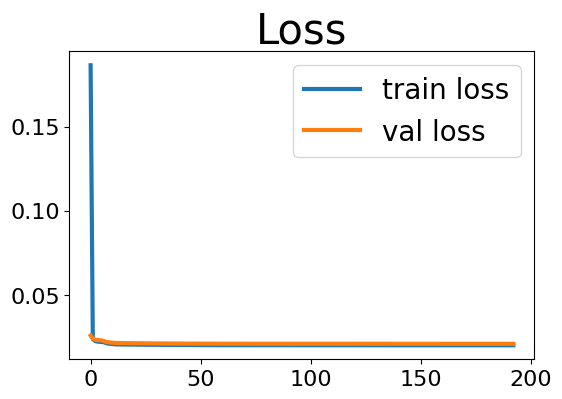

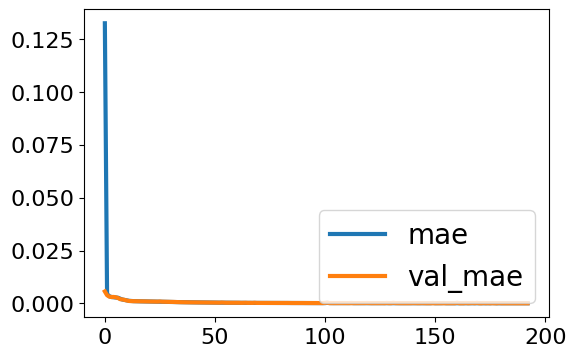

In [30]:
ch.plot_history(history)

In [55]:
#final_model.save("model/occ_cae_early_prediction_v2.4.1.h5")

In [86]:
#with open("model/history_occ_cae_v2.4.1.json", "w") as f:
    json.dump(history.history, f)
    f.close()

In [63]:
final_model = load_model("model/occ_cae_early_prediction_v2.4.1.h5")

In [64]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           80        
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           1040      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 100, 16)          1040      
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 16)          1040      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 100, 1)           65        
 ranspose)                                                       
                                                        

In [32]:
#final_model.save("model/occ_cae_early_prediction_v2.4.1.h5")

# 4. Searching optimal threshold through several methods

## 4.1 Searching threshold with validation data

In [65]:
#print(importlib.reload(ah))

reconstructed_train_inverse = ah.reconstruct_curves(final_model, x_train_scaled, max_train, len_curve, scaled=True)
reconstructed_val_inverse = ah.reconstruct_curves(final_model, x_val_scaled, max_train, len_curve, scaled=True)

reconstructed_curves_inverse shape: (700, 100)
reconstructed_curves_inverse shape: (100, 100)


In [66]:
train_mae = ah.calc_mae(x_train_inverse, reconstructed_train_inverse)
val_mae = ah.calc_mae(x_val_inverse, reconstructed_val_inverse)

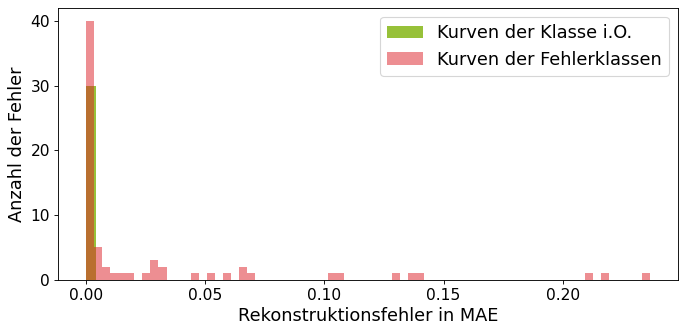

In [68]:
ah.plot_clean_fraud(y_test=y_val, test_error=val_mae, bin_num0=1, bin_num1=70, bin_width0=0.004, figsize=(10,4.5), dpi=80)

In [69]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [71]:
# iterate threshold to calculate tpr and fpr for ROC-curve

start = 0.0
end = 0.02
steps = 0.00001

val_threshold = {"threshold": [], "tpr": [], "fpr": [], "f1": [], "acc": []}

for i in np.arange(start, end, steps):
    val_threshold["threshold"].append(i)
    tpr, fpr, f1, acc, cm = ah.get_preds(y_val, threshold=i, loss=val_mae)
    val_threshold["tpr"].append(tpr)
    val_threshold["fpr"].append(fpr)
    val_threshold["f1"].append(f1)
    val_threshold["acc"].append(acc)

In [72]:
df_threshold = pd.DataFrame(val_threshold)
df_threshold

,threshold,tpr,fpr,f1,acc
0,0.00000,1.000000,1.0,0.823529,0.7
1,0.00001,1.000000,1.0,0.823529,0.7
2,0.00002,1.000000,1.0,0.823529,0.7
3,0.00003,1.000000,1.0,0.823529,0.7
4,0.00004,1.000000,1.0,0.823529,0.7
...,...,...,...,...,...
1995,0.01995,0.285714,0.0,0.444444,0.5
1996,0.01996,0.285714,0.0,0.444444,0.5
1997,0.01997,0.285714,0.0,0.444444,0.5
1998,0.01998,0.285714,0.0,0.444444,0.5


In [73]:
df_threshold[df_threshold.f1==max(df_threshold.f1)]

,threshold,tpr,fpr,f1,acc
22,0.00022,0.9,0.033333,0.940299,0.92


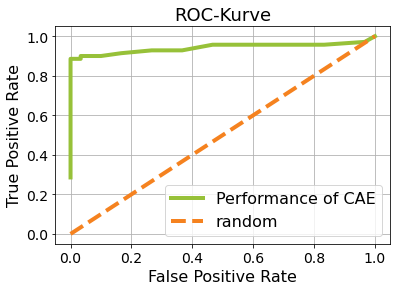

In [42]:
plt.figure(figsize=(6,4))
plt.plot(df_threshold["fpr"], df_threshold["tpr"], color=fapsc.green, linewidth=4, label="Performance of CAE")
plt.plot([0, 1], [0, 1], color=fapsc.orange, linewidth=4, linestyle="--", label="random")

plt.xlabel("False Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("True Positive Rate", fontsize=16)
plt.yticks(fontsize=14)
plt.title("ROC-Kurve", fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.grid()
plt.show()

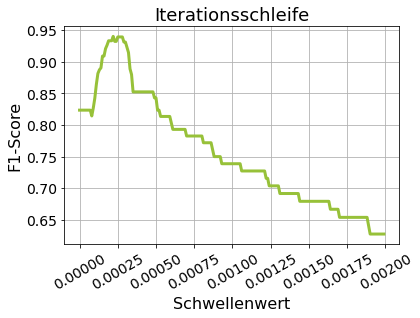

In [43]:
plt.figure(figsize=(6,4))
plt.plot(df_threshold["threshold"][:200], df_threshold["f1"][:200], linewidth=3, color=fapsc.green, label="F1-Score")
plt.scatter(df_threshold[df_threshold.f1==1]["threshold"].min(), 1, color=fapsc.black).set_zorder(2)

plt.xlabel("Schwellenwert", fontsize=16)
plt.ylabel("F1-Score", fontsize=16)
plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)
plt.title("Iterationsschleife", fontsize=18)
#plt.legend(loc="upper right", fontsize=16)
plt.grid()
plt.show()

In [74]:
threshold1 = df_threshold[df_threshold.f1==max(df_threshold.f1)]["threshold"].min()
threshold1

0.00022

## 4.2 Calculating threshold with mean and standard deviation

In [75]:
threshold2 = np.mean(train_mae) + 3*np.std(train_mae)
threshold2

0.00038077027335436746

## 4.3 Calculating threshold with max train error

In [76]:
threshold3 = max(train_mae)
threshold3

0.0014085265129688284

# 5. Evaluation

In [77]:
reconstructed_train_inverse, reconstructed_test_inverse = ah.prepare_train_test(final_model, x_train_scaled, x_test_scaled, 
                                                                                max_train, len_curve=100, 
                                                                                scaled=True)

reconstructed_train_inverse shape: (700, 100)
reconstructed_test_inverse shape: (750, 100)


In [78]:
train_mae = ah.calc_mae(x_train_inverse, reconstructed_train_inverse)
test_mae = ah.calc_mae(x_test_inverse, reconstructed_test_inverse)

## 5.1 Evaluation with optimized threshold through validation data

In [79]:
rec1, pre1, f1_1, acc1, y_pred1 = ah.get_anomaly_pred_acc(y_test, threshold=threshold1, loss=test_mae)
y_pred1

Recall: 0.8742857142857143
Precision: 0.99836867862969
F1 Score: 0.9322162985529322
Accuracy: 0.8813333333333333


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

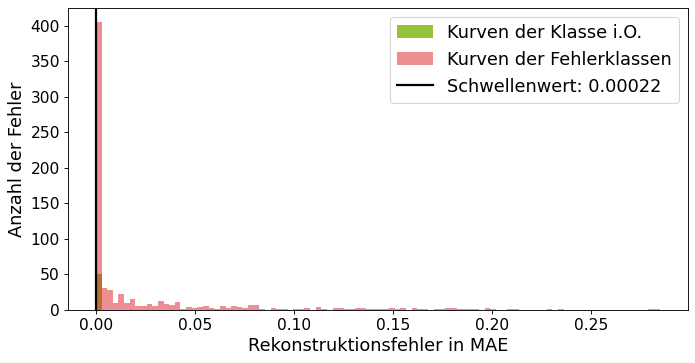

In [50]:
#print(importlib.reload(ah))
ah.plot_clean_fraud(y_test=y_test, test_error=test_mae, bin_num0=1, bin_num1=100, bin_width0=0.003,
                    threshold=threshold1, figsize=(10,5), dpi=80)

In [57]:
print(importlib.reload(ch))

<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


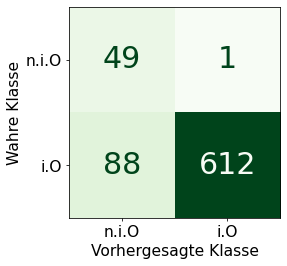

In [59]:
ch.plot_calc_cm(y_test, y_pred1, class_name=["n.i.O","i.O"], figsize=(4,4), dpi=70, fontsize=16)

In [60]:
classdict = {"cl0":[], "cl1":[], "cl2":[], "cl3":[], "cl4":[], "cl5":[], "cl6":[], "cl7":[],
             "cl16":[], "cl24":[], "cl27":[], "cl35":[], "cl37":[], "cl267":[], "cl357":[]}

In [61]:
# searching the number of misclassification in each class

for i,key in enumerate(classdict):
    if i==0:
        classdict[key].append(y_pred1.reshape(-1, 50)[i].sum())
    else:
        classdict[key].append(50 - y_pred1.reshape(-1, 50)[i].sum())


In [62]:
classdict

{'cl0': [1],
 'cl1': [0],
 'cl2': [0],
 'cl3': [1],
 'cl4': [0],
 'cl5': [0],
 'cl6': [3],
 'cl7': [17],
 'cl16': [0],
 'cl24': [0],
 'cl27': [0],
 'cl35': [6],
 'cl37': [50],
 'cl267': [4],
 'cl357': [7]}

In [80]:
res1 = ch.collect_results_occ(y_test, y_pred1, algorithm="cae_early100", params=None, 
                              best_param="threshold_val", cm=confusion_matrix(y_test, y_pred1).tolist())
res1

{'algorithm': 'cae_early100',
 'params': None,
 'best_param': 'threshold_val',
 'cm': [[49, 1], [88, 612]],
 'rec': 0.8742857142857143,
 'pre': 0.99836867862969,
 'f1': 0.9322162985529322,
 'acc': 0.8813333333333333}

In [81]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "cae_early100_val", 
                     hyperopt_result = res1)

existing file occ_hyperopt_results_v2.4.1.json opened and results of cae_early100_val saved.


## 5.2 Evaluation with optimized threshold through standard deviation

In [82]:
rec2, pre2, f1_2, acc2, y_pred2 = ah.get_anomaly_pred_acc(y_test, threshold=threshold2, loss=test_mae)
y_pred2

Recall: 0.7914285714285715
Precision: 0.9981981981981982
F1 Score: 0.8828685258964145
Accuracy: 0.804


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [83]:
res2 = ch.collect_results_occ(y_test, y_pred2, algorithm="cae_early100", params=None, 
                              best_param="threshold_std", cm=confusion_matrix(y_test, y_pred2).tolist())
res2

{'algorithm': 'cae_early100',
 'params': None,
 'best_param': 'threshold_std',
 'cm': [[49, 1], [146, 554]],
 'rec': 0.7914285714285715,
 'pre': 0.9981981981981982,
 'f1': 0.8828685258964145,
 'acc': 0.804}

In [84]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "cae_early100_std", 
                     hyperopt_result = res2)

existing file occ_hyperopt_results_v2.4.1.json opened and results of cae_early100_std saved.


## 5.3 Evaluation with optimized threshold through max reconstrucion error

In [85]:
rec3, pre3, f1_3, acc3, y_pred3 = ah.get_anomaly_pred_acc(y_test, threshold=threshold3, loss=test_mae)
y_pred3

Recall: 0.4757142857142857
Precision: 1.0
F1 Score: 0.6447241045498547
Accuracy: 0.5106666666666667


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,

In [86]:
res3 = ch.collect_results_occ(y_test, y_pred3, algorithm="cae_early100", params=None, 
                              best_param="threshold_max", cm=confusion_matrix(y_test, y_pred3).tolist())
res3

{'algorithm': 'cae_early100',
 'params': None,
 'best_param': 'threshold_max',
 'cm': [[50, 0], [367, 333]],
 'rec': 0.4757142857142857,
 'pre': 1.0,
 'f1': 0.6447241045498547,
 'acc': 0.5106666666666667}

In [87]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "cae_early100_max", 
                     hyperopt_result = res3)

existing file occ_hyperopt_results_v2.4.1.json opened and results of cae_early100_max saved.
